In [1]:
import numpy as np
import torch
from sklearn.metrics import (
    precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import time


In [2]:
# Function to load the saved model
def load_model(model_path, model_class, device='cuda'):
    model = model_class()  # Initialize the model architecture (EEGClassifier in your case)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Function to load test data from .npy files
def load_test_data():
    test_data = np.load('data/test/data.npy')
    test_labels = np.load('data/test/labels.npy')
    return test_data, test_labels


In [3]:
# Batched inference to reduce memory usage
def batched_inference(model, test_data, batch_size=64, device='cuda'):
    outputs = []
    model.eval()
    
    for i in range(0, len(test_data), batch_size):
        batch_data = torch.tensor(test_data[i:i+batch_size]).float().to(device)
        with torch.no_grad():
            batch_output = model(batch_data).cpu().numpy()  # Move to CPU to free GPU memory
        outputs.append(batch_output)
    
    outputs = np.vstack(outputs)  # Combine batches into one array
    return outputs

In [5]:
def evaluate_model_with_timing(model, test_data, test_labels, num_classes=6, batch_size=120, device='cuda'):
    # Start time for inference
    start_time = time.time()
    
    # Run batched inference
    outputs = batched_inference(model, test_data, batch_size=batch_size, device=device)
    
    # End time for inference
    end_time = time.time()
    test_duration = end_time - start_time

    # Predictions and ground truth
    predictions = np.argmax(outputs, axis=1)

    # Compute metrics
    precision = precision_score(test_labels, predictions, average='weighted')
    recall = recall_score(test_labels, predictions, average='weighted')
    f1 = f1_score(test_labels, predictions, average='weighted')
    kappa = cohen_kappa_score(test_labels, predictions)

    # Calculate AUC-ROC (multi-class)
    try:
        auc = roc_auc_score(test_labels, outputs, multi_class='ovo', average='weighted')
    except ValueError:
        auc = None
        print("AUC-ROC could not be calculated due to data formatting.")

    # Generate confusion matrix and classification report
    report = classification_report(test_labels, predictions)
    conf_matrix = confusion_matrix(test_labels, predictions)
    
    # Plot confusion matrix as an image
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig("confusion_matrix.png")  # Save confusion matrix as an image
    plt.show()

    return precision, recall, f1, kappa, auc, conf_matrix, report, test_duration



In [6]:
from model import EEGClassifier
model_path = "/home/deepak/Documents/Deepak/Students/Susmit_23CS60R75/onlyYoung/mixup05/outputs/models/eeg-classifier_seed-42_mixup_finetuned_final_model.pt"


In [11]:

# Main function to load model, test data, and evaluate
def main_with_timing():
    # Load the model
    # model_path = "models/eeg-classifier_seed-42_mixup_finetuned_training_time.pt"  # Path to your saved model
    model = load_model(model_path, EEGClassifier, device='cuda')  # EEGClassifier is your model class

    # Load test data
    test_data, test_labels = load_test_data()

    # Evaluate model and compute metrics with timing
    precision, recall, f1, kappa, auc, conf_matrix, report, test_duration = evaluate_model_with_timing(model, test_data, test_labels, num_classes=6, batch_size=64, device='cuda')

    # Print the metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Kappa: {kappa:.4f}")
    print(f"AUC: {auc:.4f}" if auc else "AUC: Not calculated")
    print(f"Test Duration: {test_duration:.4f} seconds")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Classification Report:\n{report}")

/tmp/ipykernel_355601/3188695244.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


AUC-ROC could not be calculated due to data formatting.


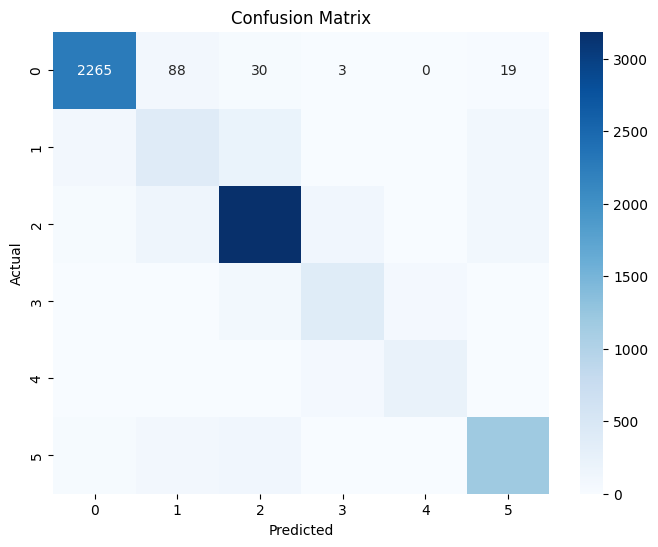

Precision: 0.8433
Recall: 0.8446
F1 Score: 0.8438
Kappa: 0.7883
AUC: Not calculated
Test Duration: 1.2491 seconds
Confusion Matrix:
[[2265   88   30    3    0   19]
 [  94  393  203    2    0  102]
 [  28  157 3185  118    0  111]
 [   2    2   75  380   65    0]
 [   1    0    1   69  234    0]
 [  28   94  114    1    0 1191]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2405
           1       0.54      0.49      0.51       794
           2       0.88      0.88      0.88      3599
           3       0.66      0.73      0.69       524
           4       0.78      0.77      0.77       305
           5       0.84      0.83      0.84      1428

    accuracy                           0.84      9055
   macro avg       0.77      0.77      0.77      9055
weighted avg       0.84      0.84      0.84      9055



In [12]:
main_with_timing()